# ==========================================================================================
# AE3 - Exercicio 2 letra A - Deslocamentos
# 1) Importando bibliotecas pytorch
# ==========================================================================================

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==========================================================
# 2) Constantes, domínio e solução analítica (para checagem)
# solução analítica (Beer & Johnston)
# ==========================================================

In [2]:
# --- parâmetros SI ---
L  = 3.0                      # m
I  = 6510e-8                  # m^4
E  = 21000e7                  # Pa
P  = 16e3                     # N
EI = E*I

# solução analítica (Beer & Johnston)
def w_analit(x):
    x = np.asarray(x)
    return (P/EI)*(0.5*L*x**2 - (1.0/6.0)*x**3)

def theta_analit(x):
    x = np.asarray(x)
    return (P/EI)*(L*x - 0.5*x**2)

x_plot = np.linspace(0, L, 200)[:, None]
w_tip_analit  = (P*L**3)/(3*EI)
th_tip_analit = (P*L**2)/(2*EI)
print(f"[Analítico] w_max = {w_tip_analit*1e3:.3f} mm | theta(L) = {th_tip_analit:.6f} rad ({np.degrees(th_tip_analit):.3f} deg)")

# --- HIPERPARÂMETROS (com pesos de perda) ---
HIDDEN_LAYERS   = 4
NEURONS_PER_LAY = 50
ACTIVATION_NAME = "tanh"       # 'tanh' | 'relu' | 'silu'
Nf = 200                       # pontos internos
Nb0 = 8                        # pontos em x=0
NbL = 24                       # pontos em x=L (reforçado)
LR = 1e-3                      # Adam
EPOCHS = 8000
USE_LBFGS = True

# pesos (rebalanceamento dos termos de contorno do extremo livre)
LAMBDA_PDE = 1.0
LAMBDA_ML  = 10.0              # w''(L)=0
LAMBDA_VL  = 10.0              # EI*w'''(L)=-P

# escalas (normalização leve)
w_scale = float(w_tip_analit)  # ~ ordem de grandeza de w
print("[Config PINN corrigida]")
print(f"  - Rede: {HIDDEN_LAYERS} camadas escondidas × {NEURONS_PER_LAY} neurônios (ativação: {ACTIVATION_NAME})")
print(f"  - Pontos: Nf={Nf}, Nb0={Nb0}, NbL={NbL}")
print(f"  - Otimizadores: Adam(lr={LR}){' + L-BFGS' if USE_LBFGS else ''}; Épocas(Adam)={EPOCHS}")
print(f"  - Pesos de perda: PDE={LAMBDA_PDE}, w''(L)={LAMBDA_ML}, shear={LAMBDA_VL}")

[Analítico] w_max = 10.533 mm | theta(L) = 0.005267 rad (0.302 deg)
[Config PINN corrigida]
  - Rede: 4 camadas escondidas × 50 neurônios (ativação: tanh)
  - Pontos: Nf=200, Nb0=8, NbL=24
  - Otimizadores: Adam(lr=0.001) + L-BFGS; Épocas(Adam)=8000
  - Pesos de perda: PDE=1.0, w''(L)=10.0, shear=10.0


# ==================================
# 3) Definição da PINN (PDE e C.C.)
# ==================================

In [3]:
def grad(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               create_graph=True, retain_graph=True)[0]

def safe_grad(y, x):
    g = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                            create_graph=True, retain_graph=True, allow_unused=True)[0]
    return torch.zeros_like(x) if g is None else g

def make_activation(name):
    name = name.lower()
    if name == "tanh": return nn.Tanh()
    if name == "relu": return nn.ReLU()
    if name == "silu": return nn.SiLU()
    raise ValueError("Ativação inválida.")

# w(x) = w_scale * x^2 * f(ξ),  ξ=x/L  -> impõe w(0)=w'(0)=0 (hard)
class FCN(nn.Module):
    def __init__(self, hidden_layers, neurons, act_name):
        super().__init__()
        act = make_activation(act_name)
        layers = [nn.Linear(1, neurons), act]
        for _ in range(hidden_layers-1):
            layers += [nn.Linear(neurons, neurons), act]
        layers += [nn.Linear(neurons, 1)]
        self.net = nn.Sequential(*layers)
        self.hidden_layers = hidden_layers
        self.neurons = neurons
        self.act_name = act_name
    def forward(self, x):
        xi = x / L
        f  = self.net(xi)
        return w_scale * (x**2) * f

net = FCN(HIDDEN_LAYERS, NEURONS_PER_LAY, ACTIVATION_NAME).to(device)

def count_params(m): return sum(p.numel() for p in m.parameters())
print("[Resumo da Rede]")
print(f"  - Arquitetura: [1] + {[NEURONS_PER_LAY]*HIDDEN_LAYERS} + [1] | #Par.: {count_params(net):,}")

# >>> PONTOS COMO LEAF TENSORS <<<
def leaf(t): return t.detach().requires_grad_(True)

x_f = leaf(torch.rand(Nf, 1, device=device) * L)          # (0,L)
x0  = leaf(torch.zeros(Nb0, 1, device=device))            # 0
xL  = leaf(torch.full((NbL, 1), L, device=device))        # L (sem multiplicação!)


[Resumo da Rede]
  - Arquitetura: [1] + [50, 50, 50, 50] + [1] | #Par.: 7,801


# =============================================
# 4) Treino (Adam + L-BFGS) e pós-processamento
# =============================================

In [4]:
mse = nn.MSELoss()

def physics_residual(x):
    w = net(x)
    w_x   = grad(w, x)
    w_xx  = grad(w_x, x)
    w_xxx = grad(w_xx, x)
    w_xxxx= grad(w_xxx, x)
    return w_xxxx

def loss_func():
    # PDE
    r_f = physics_residual(x_f)
    loss_pde = LAMBDA_PDE * mse(r_f, torch.zeros_like(r_f))
    # CC x=L
    wL     = net(xL)
    wL_x   = grad(wL, xL)
    wL_xx  = grad(wL_x, xL)
    wL_xxx = grad(wL_xx, xL)
    loss_ML = LAMBDA_ML * mse(wL_xx, torch.zeros_like(wL_xx))
    loss_VL = LAMBDA_VL * mse(EI*wL_xxx + P, torch.zeros_like(wL_xxx))
    loss = loss_pde + loss_ML + loss_VL
    return loss, (loss_pde.item(), loss_ML.item(), loss_VL.item())

# --- Adam ---
opt = torch.optim.Adam(net.parameters(), lr=LR)
loss_hist = []
print("[Treino] Adam")
for epoch in range(EPOCHS):
    # (opcional) reamostrar os pontos internos a cada 200 épocas
    if (epoch % 200) == 0:
        x_f = leaf(torch.rand(Nf, 1, device=device) * L)

    opt.zero_grad()
    loss, parts = loss_func()
    loss.backward()
    opt.step()
    loss_hist.append(loss.item())
    if (epoch+1) % 1000 == 0:
        p = tuple(f"{v:.1e}" for v in parts)
        print(f"  epoch {epoch+1:5d}: loss={loss.item():.3e}  parts={p}")

# --- L-BFGS (mantém os pontos fixos) ---
if USE_LBFGS:
    print("[Treino] L-BFGS (refino)")
    optimizer = torch.optim.LBFGS(
        net.parameters(), lr=1.0, max_iter=500, history_size=50, line_search_fn="strong_wolfe"
    )
    def closure():
        optimizer.zero_grad()
        l, _ = loss_func()
        l.backward()
        return l
    lbfgs_loss = optimizer.step(closure).item()
    print(f"  LBFGS final loss: {lbfgs_loss:.3e}")

# --- Pós-processamento ---
with torch.no_grad():
    x_plot_t = torch.tensor(x_plot, dtype=torch.float32, device=device)
    w_pred = net(x_plot_t).cpu().numpy().squeeze(-1)

xL_ind = torch.tensor([[L]], dtype=torch.float32, device=device, requires_grad=True)
theta_L_t = safe_grad(net(xL_ind), xL_ind)
theta_L = theta_L_t.detach().cpu().squeeze().item()

w_tip_pred = float(w_pred[-1])
w_err  = abs(w_tip_pred - w_tip_analit)/abs(w_tip_analit)
th_err = abs(theta_L - th_tip_analit)/abs(th_tip_analit)

print("\n[Resumo dos Resultados]")
print(f"  w_max (PINN)  = {w_tip_pred:.6e} m  ({1e3*w_tip_pred:.3f} mm)   |  erro rel. = {100*w_err:.3f}%")
print(f"  theta(L) PINN = {theta_L:.6f} rad  ({np.degrees(theta_L):.3f} deg) |  erro rel. = {100*th_err:.3f}%")


[Treino] Adam
  epoch  1000: loss=5.661e-07  parts=('5.7e-07', '1.2e-18', '0.0e+00')
  epoch  2000: loss=6.587e-07  parts=('6.6e-07', '1.4e-19', '0.0e+00')
  epoch  3000: loss=6.232e-07  parts=('6.2e-07', '1.4e-19', '0.0e+00')
  epoch  4000: loss=6.159e-07  parts=('6.2e-07', '1.4e-19', '0.0e+00')
  epoch  5000: loss=6.123e-07  parts=('6.1e-07', '1.4e-19', '0.0e+00')
  epoch  6000: loss=6.602e-07  parts=('6.6e-07', '1.4e-19', '0.0e+00')
  epoch  7000: loss=6.212e-07  parts=('6.2e-07', '1.4e-19', '0.0e+00')
  epoch  8000: loss=6.690e-07  parts=('6.7e-07', '1.4e-19', '0.0e+00')
[Treino] L-BFGS (refino)
  LBFGS final loss: 6.690e-07

[Resumo dos Resultados]
  w_max (PINN)  = 8.832077e-03 m  (8.832 mm)   |  erro rel. = 16.150%
  theta(L) PINN = 0.004688 rad  (0.269 deg) |  erro rel. = 10.987%



# =============================================
# 5) Gráficos (comparação e função de perda)
# =============================================


# comparação com analítica 
# perda total (Adam)

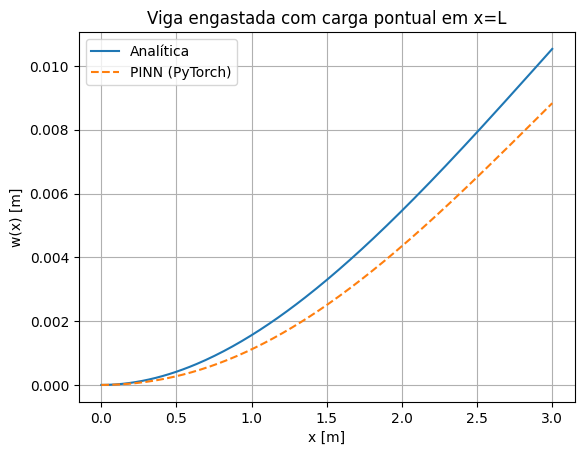

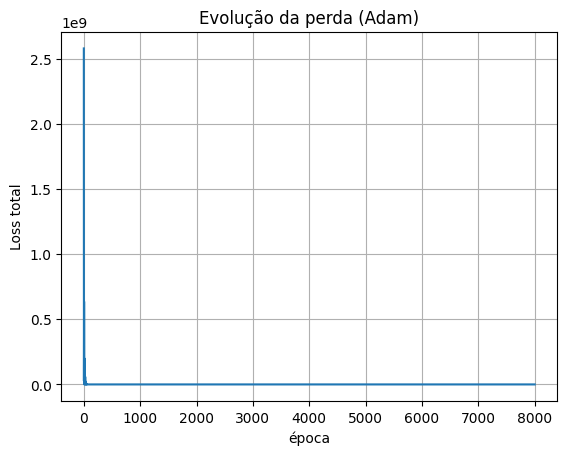

In [5]:
# deslocamento
plt.figure()
plt.plot(x_plot, w_analit(x_plot), label="Analítica")
plt.plot(x_plot, w_pred, "--", label="PINN (PyTorch)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.title("Viga engastada com carga pontual em x=L")
plt.grid(True); plt.legend(); plt.show()

# perda total (Adam)
plt.figure()
plt.plot(loss_hist)
plt.xlabel("época")
plt.ylabel("Loss total")
plt.title("Evolução da perda (Adam)")
plt.grid(True); plt.show()